In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path
import pytesseract
from pytesseract import Output
from PIL import Image
import re

Steps to convert pdf table to excel-

1. Get the tablular structure from the image
2. Crop all the rows from the table 
3. Apply OCR using pytesseract on the crops separately to get the text and location
4. Post-process output in the right format and convert to excel

Extract the table using Morphological Transformations

In [2]:
# convert pdf to PIL image
pil_image = convert_from_path('input/test_input.pdf', 500, last_page=1,  strict=True)
# Convert PIL to OpenCV
image = np.array(pil_image[0]) 
# Convert RGB to BGR 
image = image[:, :, ::-1].copy() 
# Convert to greyscale
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ind_ = list(zip(np.where(image_grey==255)[0], np.where(image_grey==255)[1]))
for i in ind_:
    image_grey[i[0]][i[1]] = 0
    
# Thresholding the image
(thresh, img_bin) = cv2.threshold(image_grey, 128, 255,cv2.THRESH_BINARY|  cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin

# Defining a kernel length
kernel_length = np.array(image_grey).shape[1]//80
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


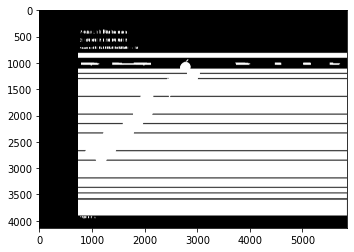

In [3]:
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))

The lines are broken in the table because of the watermark so we further use kernels to connect broken lines

In [4]:
# Connect the broken lines

img_final_bin_inv = 255 - img_final_bin
kernel_new = np.ones((5,1000), np.uint8)  # note this is a horizontal kernel
img_final_bin_hor = cv2.dilate(img_final_bin_inv, kernel_new, iterations=1)
img_final_bin_hor = cv2.erode(img_final_bin_hor, kernel_new, iterations=1) 

img_final_bin_hor = 255 - img_final_bin_hor

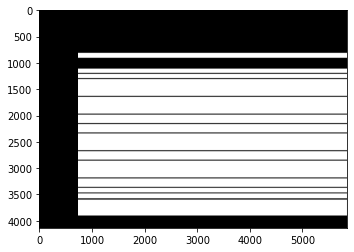

In [5]:
plt.imshow(cv2.cvtColor(img_final_bin_hor, cv2.COLOR_BGR2RGB))

As clearly shown above, the lines are fixed and we successfully extracted the table

Now, we detect contours and crop the rows from the table

In [6]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin_hor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# function to sort_contours in from top-to-left
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

# crop different rows from the tablle
rows = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    new_img = image_grey[y:y+h, x:x+w]
    rows.append(new_img)

Then we perform OCR using `pytesseract` to extract the table content

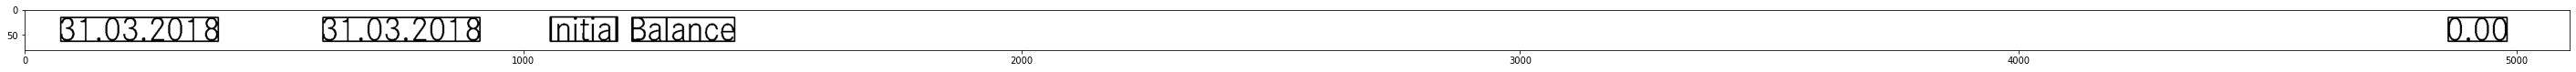

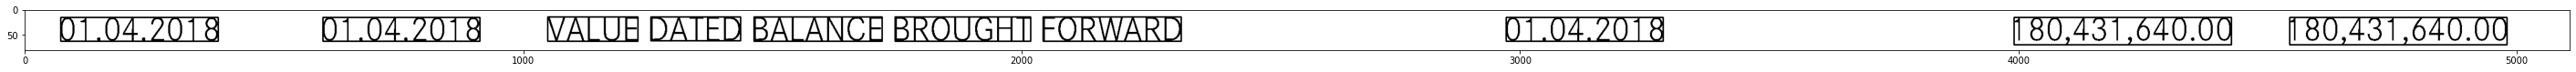

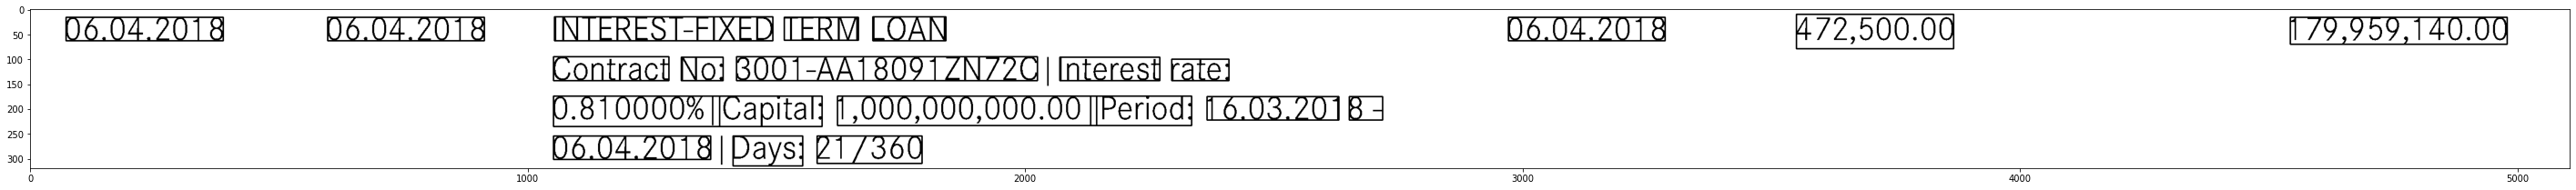

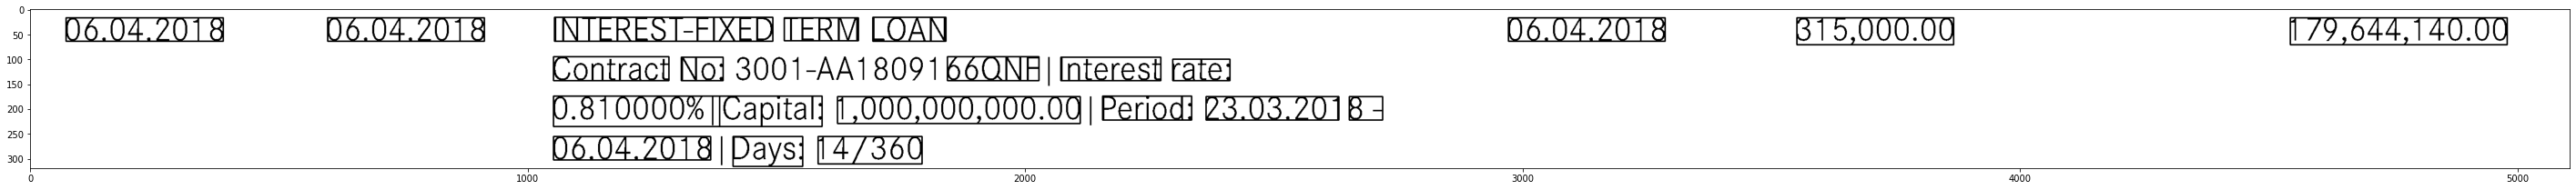

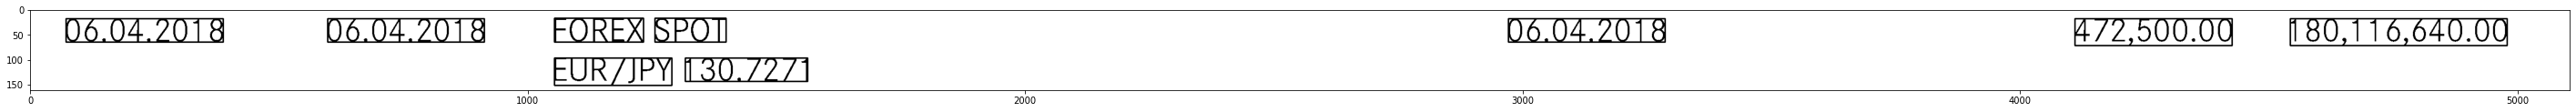

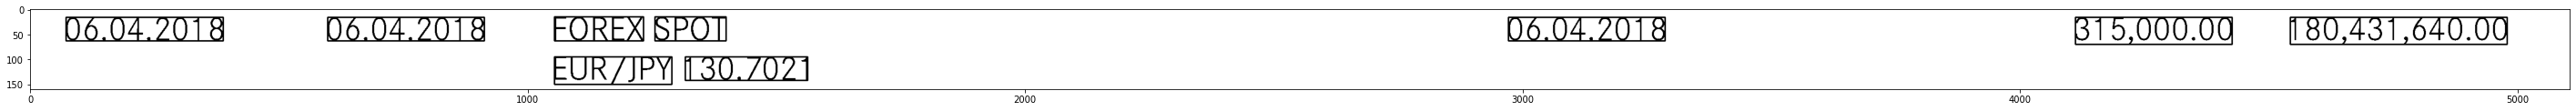

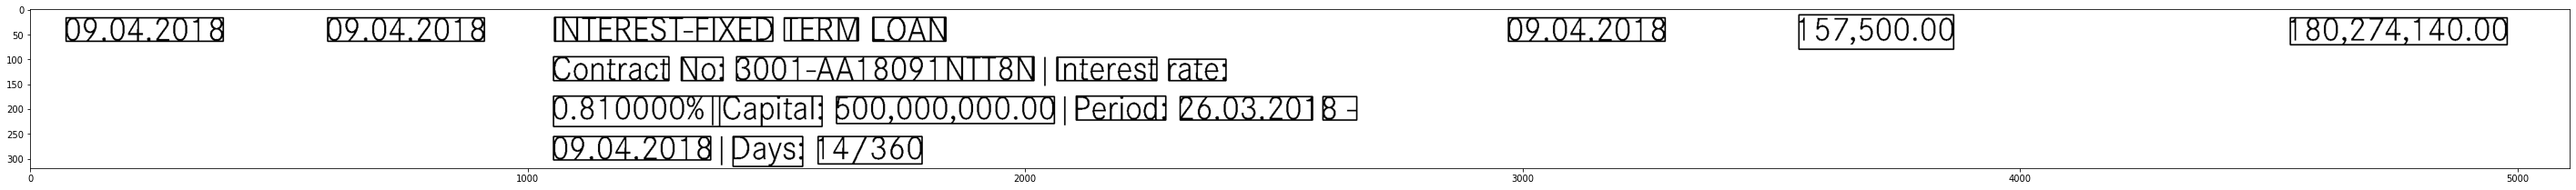

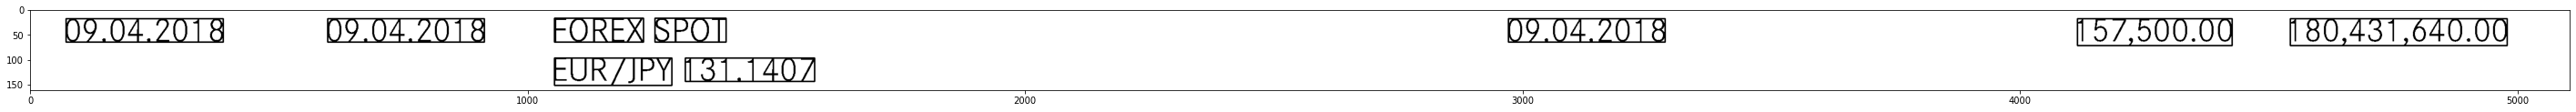

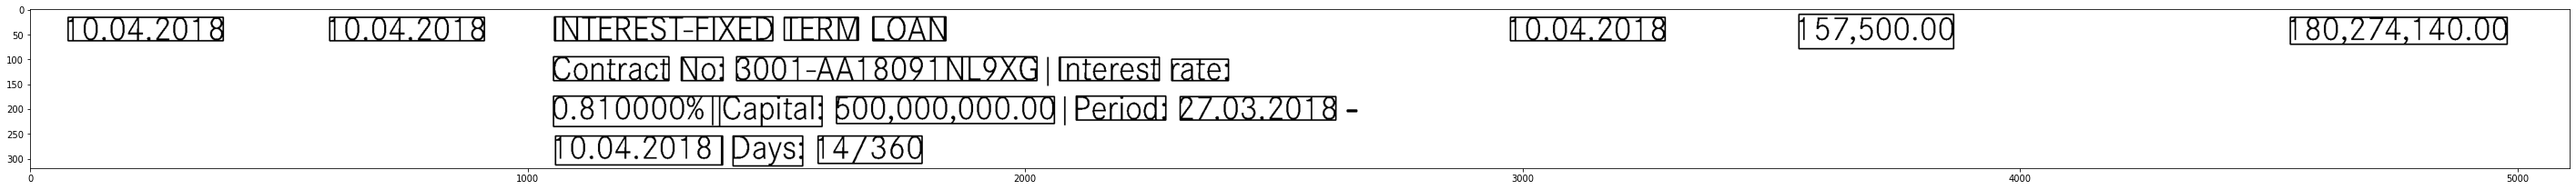

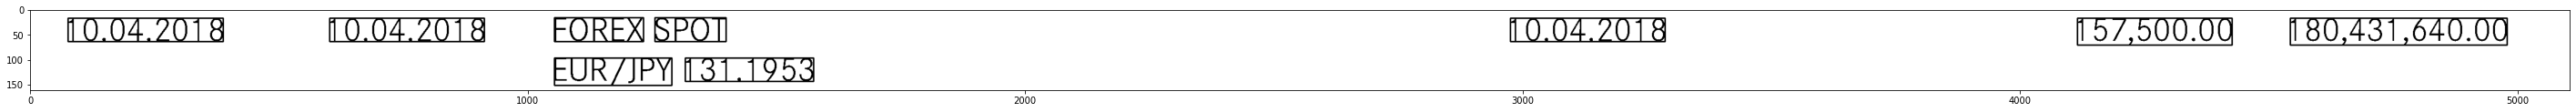

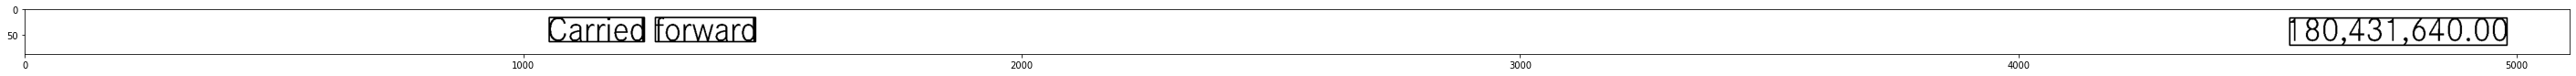

In [7]:
#OCR on cropped rows : get text and box around the text

box_info = []
for j in range(1,12):
    box_dict = {}
    im = rows[j]
    
    #preprocess
    (thresh, img_bin) = cv2.threshold(im, 128, 255,cv2.THRESH_BINARY|  cv2.THRESH_OTSU)
    
    # ocr 
    d = pytesseract.image_to_data(img_bin, output_type=Output.DICT)
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 0:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            if w>h:
                cv2.rectangle(img_bin, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if d['text'][i]!='':
                box_dict[(x,y)] = d['text'][i]
    box_info.append(box_dict)
    
    #visualize
    plt.figure(j,(50,25))
    plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB))


From the row crops above, we estimate starting points of columns and group texts belonging to the same column together

In [8]:
# extrapolate positions of starting points of columns using 'box_info' 
#and 'canopy_technical_test_input.pdf'
approx = [70,596,1047,2970,3549,3989,4542]

# Group boxes in the same column together
final_boxes = []
for box in box_info:
    
    dict_ = {i:[] for i in range(7)}
    ct = 0

    for i,keys in enumerate(box):
        point_found = False
        for j, t in enumerate(approx):
            lower = approx[j]-10
            if j == 6:
                higher = 5000
            else:
                higher = approx[j+1]-10

            if keys[0] > lower and keys[0]<higher:                 
                dict_[j].append(keys)
                last_ind = j
                point_found = True
                break
        if point_found == False:
            dict_[last_ind].append(keys)
    
    final_boxes.append(dict_)

Finally, we convert the data to an Excel file
            

In [9]:
# Create an excel sheet
columns = ['Booking Date', 'Txn Date', 'Booking Text', 'Value Date', 'Debit',
          'Credit', 'Balance']
data_dict = {x:[] for x in columns}

for i, box in enumerate(final_boxes):
    for key in final_boxes[i]:
        string = ''
        
        # for 'Booking text' column
        if len(final_boxes[i][key]) > 1:
            for val in final_boxes[i][key]:
                string += str(box_info[i][val]) + ' '
                
        # for remaining columns
        elif len(final_boxes[i][key]) == 1:
            string = box_info[i][final_boxes[i][key][0]]
            if len(re.findall("[\d]{1,2}.[\d]{1,2}.[\d]{4}",string))>0:
                segments = string.split('.')
                string = segments[2] + '/' + segments[1] + '/' + segments[0] 
            elif ',' in string:
                string = string.replace(",","").split('.')[0]
        
        data_dict[columns[key]].append(string)
        
df = pd.DataFrame(data_dict)
df.to_excel('output/pdf2excel.xlsx', index = False)

In [10]:
# visualize the data inside the excel sheet
df

,Booking Date,Txn Date,Booking Text,Value Date,Debit,Credit,Balance
0,2018/03/31,2018/03/31,Initial Balance,,,,0.00
1,2018/04/01,2018/04/01,VALUE DATED BALANCE BROUGHT FORWARD,2018/04/01,,180431640,180431640
2,2018/04/06,2018/04/06,INTEREST-FIXED TERM LOAN Contract No: 3001-AA1...,2018/04/06,472500,,179959140
3,2018/04/06,2018/04/06,INTEREST-FIXED TERM LOAN Contract No: 66QNF | ...,2018/04/06,315000,,179644140
4,2018/04/06,2018/04/06,FOREX SPOT EUR/JPY 130.7271,2018/04/06,,472900,180116640
5,2018/04/06,2018/04/06,FOREX SPOT EUR/JPY 130.7021,2018/04/06,,315000,180431640
6,2018/04/09,2018/04/09,INTEREST-FIXED TERM LOAN Contract No: 3001-AA1...,2018/04/09,157500,,180274140
7,2018/04/09,2018/04/09,FOREX SPOT EUR/JPY 131.1407,2018/04/09,,197500,180431640
8,2018/04/10,2018/04/10,INTEREST-FIXED TERM LOAN Contract No: 3001-AA1...,2018/04/10,157500,,180274140
9,2018/04/10,2018/04/10,FOREX SPOT EUR/JPY 131.1953,2018/04/10,,197500,180431640
